In [1]:
#Run this cell before the other stuff
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
#reading in the data
players <- read_csv("https://raw.githubusercontent.com/nothingbutash/dsci-100-2024w2-group-006-2/refs/heads/main/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players <- players |>
    #Changing column names to be more uniform (removed camel case and capitalization)
    #Also had to make subscribe a factor rather than logical, as classification does not work otherwise
    mutate(experience = as_factor(experience), hashed_email = hashedEmail, age = Age, subscribe = as_factor(subscribe)) |>
    select(-hashedEmail, -Age)
players

experience,subscribe,played_hours,name,gender,hashed_email,age
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Pro,TRUE,30.3,Morgan,Male,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9
Veteran,TRUE,3.8,Christian,Male,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17
Veteran,FALSE,0.0,Blake,Male,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,Dylan,Prefer not to say,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,17
Amateur,FALSE,2.3,Harlow,Male,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,17
Pro,TRUE,0.2,Ahmed,Other,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,NA


sample_mean,sample_med,sample_sd
<dbl>,<dbl>,<dbl>
20.52062,19,6.174667


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


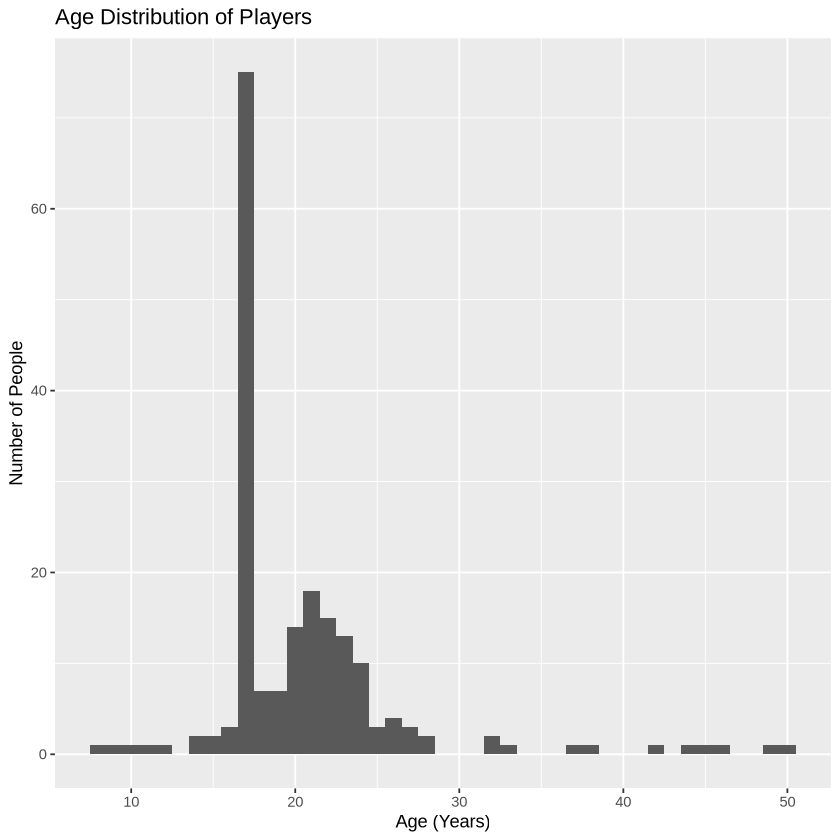

In [4]:
sample_stats <- players |>
    #calculating the mean, median, and standard deviation with summarize
    summarize(sample_mean = mean(age, na.rm = TRUE), sample_med = median(age, na.rm = TRUE), sample_sd = sd(age, na.rm = TRUE))
sample_stats

sample_distribution <- ggplot(players, aes(x = age)) + 
   geom_histogram(binwidth = 1) +
   labs(x = "Age (Years)", y = "Number of People") +
   ggtitle("Age Distribution of Players")
sample_distribution

In [5]:
subscribed_players <- players |>
    filter(subscribe == TRUE) |>
    nrow()
nonsubscribed_players <- players |>
    filter(subscribe == FALSE) |>
    nrow()
print(paste0(subscribed_players, " players out of 196 are subscribed, aka ", subscribed_players/196*100, " percent."))


[1] "144 players out of 196 are subscribed, aka 73.469387755102 percent."


**(3)**
Above (at [25]) I loaded and wrangled the dataset. The data appears tidy (one observation per row, value per cell, and variable per column).

The table of mean values is below:

In [6]:
#It was a fairly simple process to get a table of the numeric variable's mean values, as I applied the process learned in class
mean_table <- players |>
    select(played_hours,age) |>
    map_df(mean, na.rm = TRUE)
# noticed that there's at least one NA value in Age (???) so I had to remove them
mean_table

played_hours,age
<dbl>,<dbl>
5.845918,20.52062


The subscription percentages appear to be quite similar. This may not be a good predictor (or be problematic to analyze). However, prior to further predictive analysis this is unproven.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


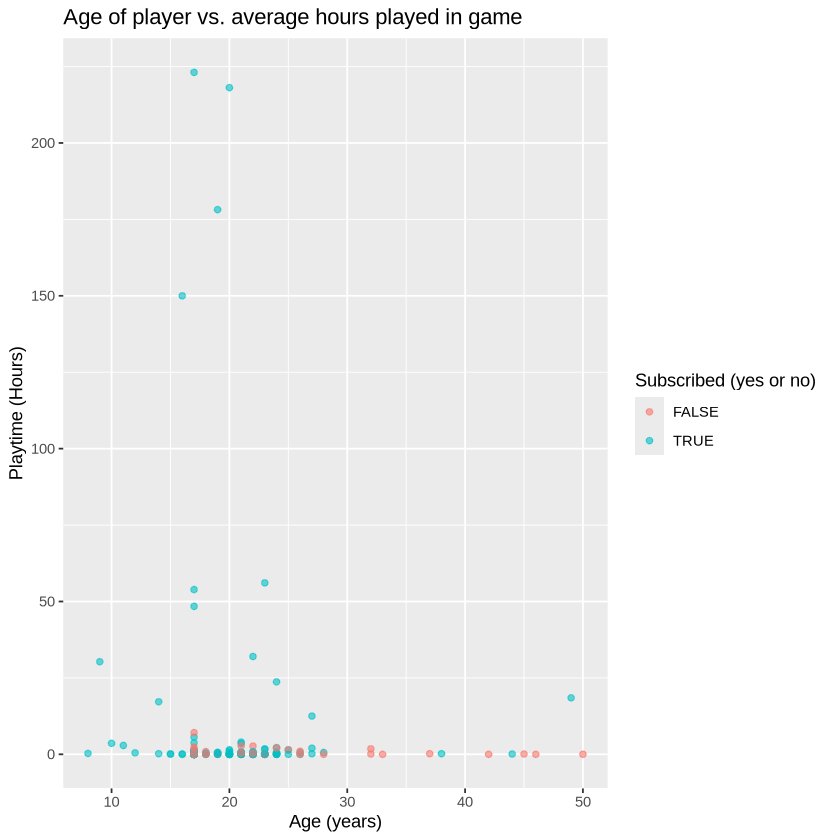

In [7]:
#For this visualization, I plan to plot age against playtime, with colour denoting subscription status (similar to the cancer classification example from class)
playtime_age_plot <- players |>
    ggplot(aes(x = age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (years)", y = "Playtime (Hours)", color = "Subscribed (yes or no)", title = "Age of player vs. average hours played in game")

playtime_age_plot

It appears most players have playtimes below 10 hours, and anyone above that is subscribed, which is intriguing. Additionally, higher playtimes are more common among younger people (age > 30), emphasizing the importance of scaling and centering the data.

Warning message:
“Removed 17 rows containing missing values or values outside the scale range
(`geom_point()`).”


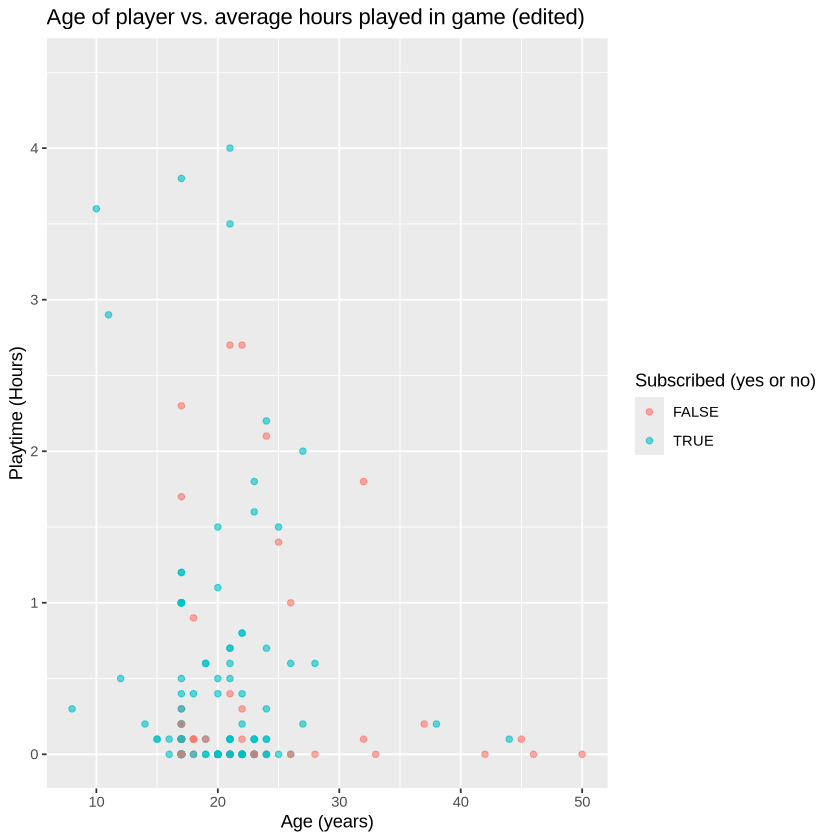

In [8]:
#cut out extreme outliers to provide better visual of data points
playtime_age_plot_better_visual <- playtime_age_plot +
    ylim(0, 4.5) +
    labs(title = "Age of player vs. average hours played in game (edited)")
playtime_age_plot_better_visual


To start off, we will analyze whether age is a good predictor of subscription status. To do this I will split the data with 75% going to training and 25% going to testing, with the strata being the age.

In [30]:
players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

Made a recipe for predicting subscribe based on age.

In [31]:
players_recipe <- recipe(subscribe ~ age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 


Made the model specification, a knn model for classification.

In [32]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

Made the workflow for tuning the model, collected the metrics, and found the best value of k.

In [ ]:
players_vfold <- players_train |>
    vfold_cv(v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 116, by = 1))

knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()
knn_results



→ A | warning: 116 samples were requested but there were 117 rows in the data. 112 will be used.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1
There were issues with some computations   A: x3   B: x1



Now we will get the best k value in terms of accuracy. This can also be plotted as a visualization.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
23,accuracy,binary,0.7530583,4,0.02289292,Preprocessor1_Model23
24,accuracy,binary,0.7530583,4,0.02289292,Preprocessor1_Model24


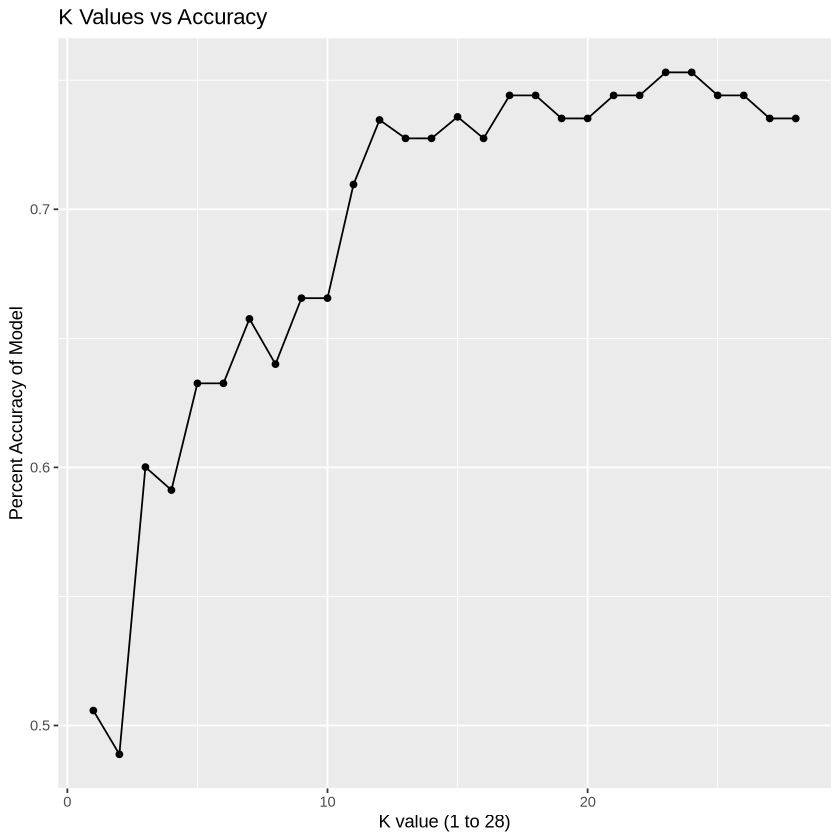

In [48]:
best_k <- knn_results |>
    filter(.metric == "accuracy") |>
    slice_max(order_by = mean, n = 1)
best_k

best_k_plot <- knn_results |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K value (1 to 28)", y = "Percent Accuracy of Model", title = "K Values vs Accuracy")
best_k_plot

Since 23 and 24 work equally well, we will choose 23 for the possibly lower computation cost. Now we will train a knn classification model with our best k of 23.

In [43]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
      set_engine("kknn") |>
      set_mode("classification")

In [44]:
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

Now we need to get the accuracy of the model on the testing set.

In [45]:
model_accuracy <- predict(players_fit, players_test) |>
    bind_cols(players_test) |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    head(1) |>
    pull()
model_accuracy

[1] 0.7346939

Our accuracy with the model trained on age, is 73%. This is greater than 55%, thus age is a good predictor of subscription status.